In [1]:
import os
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
tile_id = "S2A_32UQB_20240430_0_L2A" #"S2B_43RGP_20220218_0_L2A" #"S2A_32UQB_20240430_0_L2A"
path_abs = f"C:\\Users\\alena.bakhoryna\\Documents\\code\\niva_check\\data\\accuracy\\workflow\\{tile_id}"
path_pred_tile = os.path.join(path_abs, f"predicted\\field-boundaries-{tile_id}-v1.0.1.gpkg") # gpkg
path_gt_tile = os.path.join(path_abs, "tile\\cadastre_combined_0.gpkg")

In [3]:
pred_tile = gpd.read_file(path_pred_tile)
gt_tile = gpd.read_file(path_gt_tile)
pred_tile = pred_tile.to_crs(gt_tile.crs) # epsg = 32643 for india tile S2B_43RGP_20220218_0_L2A

# Area

In [63]:
pred_tile.crs

<Projected CRS: EPSG:32632>
Name: WGS 84 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 6°E and 12°E, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Austria. Cameroon. Denmark. Equatorial Guinea. France. Gabon. Germany. Italy. Libya. Liechtenstein. Monaco. Netherlands. Niger. Nigeria. Norway. Sao Tome and Principe. Svalbard. Sweden. Switzerland. Tunisia. Vatican City State.
- bounds: (6.0, 0.0, 12.0, 84.0)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

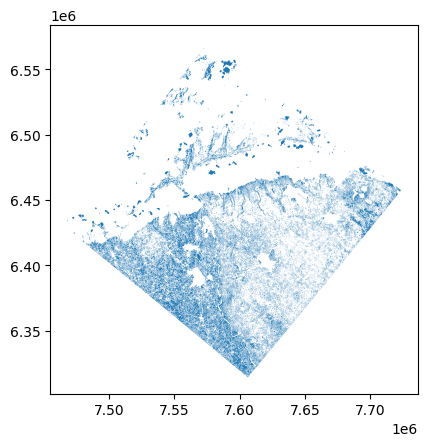

In [44]:
pred_tile.plot() # other tile crs

<AxesSubplot:>

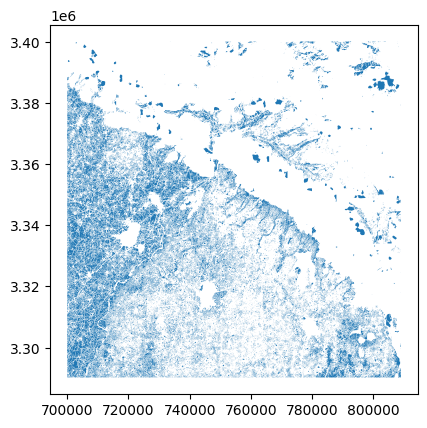

In [48]:
pred_tile.plot()

In [49]:
pred_tile["area"] = pred_tile.area

In [31]:
gt_tile[(gt_tile["area"] < 900)].to_file(os.path.join(path_abs, "area_ls_900_gt.gpkg"))

In [52]:
pred_tile[(pred_tile["area"] < 1000)]

,geometry,area
38,"POLYGON ((772231.25 3400007.45, 772178.75 3400...",968.415929
83,"POLYGON ((787692.75 3399991.25, 787706.25 3400...",931.871442
141,"POLYGON ((800514.583 3399786.25, 800496.75 339...",937.878708
170,"POLYGON ((775146.25 3397938.75, 775118.75 3397...",925.425022
195,"POLYGON ((778997.5 3397871.25, 778986.25 33978...",951.598744
...,...,...
98735,"POLYGON ((780581.25 3290220.948, 780570.607 32...",961.709081
98865,"POLYGON ((795629.833 3290306.25, 795625.306 32...",920.820812
98871,"POLYGON ((796447.917 3290353.75, 796426.25 329...",977.118333
98877,"POLYGON ((791881.107 3290386.25, 791881.25 329...",965.405763


In [53]:
len(pred_tile)

99075

In [55]:
pred_tile.area.mean(), pred_tile.area.min(), pred_tile.area.max() # for india

(23509.845323146816, 900.0127306317057, 8473105.802739847)

In [32]:
len(pred_tile[pred_tile["area"] < 1000]), len(pred_tile[pred_tile["area"] < 1000]) / len(pred_tile), len(pred_tile)

(11896, 0.15927805374429285, 74687)

In [28]:
gt_tile['area'] = gt_tile.area

In [35]:
len(gt_tile[gt_tile["area"] < 900]), len(gt_tile[gt_tile["area"] < 900]) / len(gt_tile), len(gt_tile)

(324, 0.005405315226639529, 59941)

In [30]:
len(gt_tile)

59941

# Metrics

In [116]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../src/")
sys.path.append("../../src/other/")

import os
import pandas as pd
import numpy as np
import random
import shapely as shp
from other.utils_plot import draw_bbox_bounds
from other.utils import display_tile, match_predicted_validation_fields, \
visualize_missing_stats, metrics_computation, get_edge_metrics
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Visualizations

In [16]:
begin_x, begin_y, len_xy = 2400, 2400, 500
minx, miny, maxx, maxy = gt_tile.total_bounds
xmin, xmax, ymax, ymin = (minx + begin_x * 10,
                          minx + (begin_x + len_xy) * 10,
                          maxy - begin_y * 10,
                          maxy - (begin_y + len_xy) * 10)

In [17]:
cadastre = (gt_tile
                .clip_by_rect(xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax))
predicted = (pred_tile
             .clip_by_rect(xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax))

(5670999.4918233985, 5675999.4918233985)

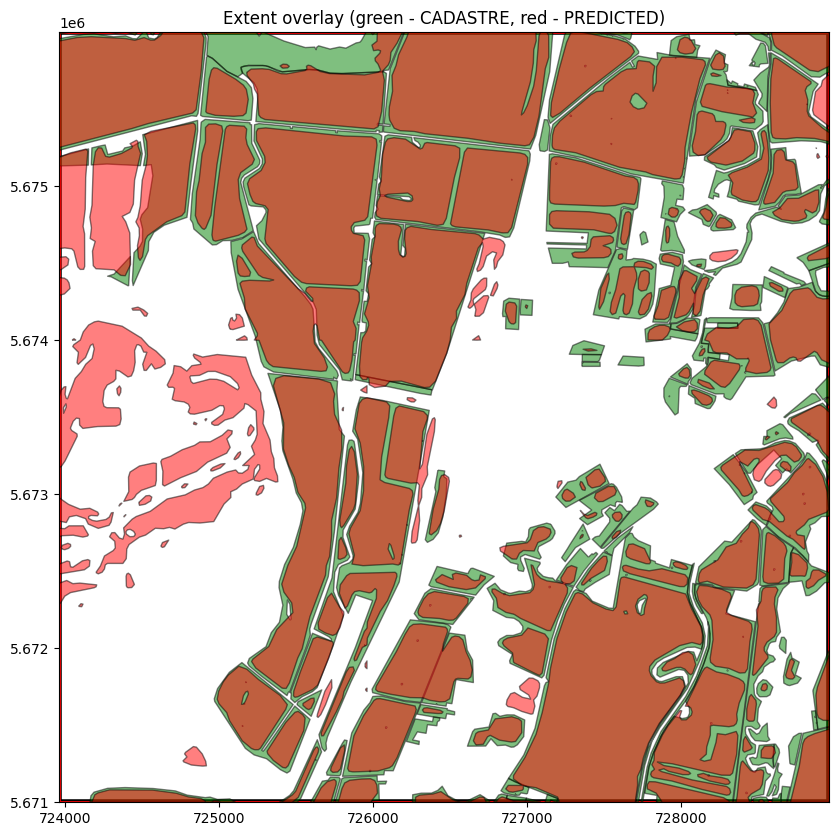

In [83]:
fig, axs = plt.subplots(figsize=(15, 10), ncols=1, sharey=True)
draw_bbox_bounds(ax=axs, bounds=(xmin, ymin, xmax, ymax))
cadastre.plot(ax=axs, color='green', alpha=0.5, edgecolor='k')
predicted.plot(ax=axs, color='red', alpha=0.5, edgecolor='k')
axs.set_title(f'Extent overlay (green - CADASTRE, red - PREDICTED)')
axs.set_xlim(xmin, xmax)
axs.set_ylim(ymin, ymax)

In [90]:
cadastre[cadastre.area > 6 * 10**5]

23044    POLYGON ((726877.358 5671154.647, 726976.884 5...
23136    POLYGON ((726195.62 5674539.886, 726203.141 56...
23186    POLYGON ((725767.617 5673735.849, 725763.634 5...
23189    POLYGON ((725474.453 5675387.463, 725754.244 5...
23201    POLYGON ((726065.073 5675351.96, 726067.663 56...
dtype: geometry

In [109]:
gt_polygon = cadastre[cadastre.area.argmax():cadastre.area.argmax()+1]

In [110]:
gt_polygon

23044    POLYGON ((726877.358 5671154.647, 726976.884 5...
dtype: geometry

In [115]:
pred_polygons = predicted[predicted.intersects(gt_polygon.geometry.iloc[0])]

C:\Users\alena.bakhoryna\AppData\Local\anaconda3\envs\nivaenv\lib\site-packages\shapely\predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


<AxesSubplot:>

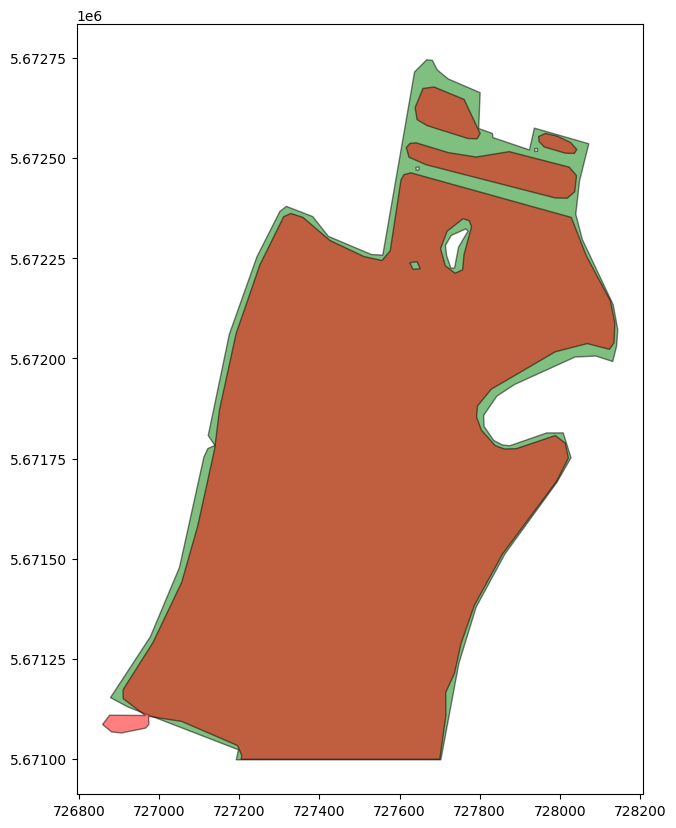

In [116]:
fig, axs = plt.subplots(figsize=(15, 10), ncols=1, sharey=True)
gt_polygon.plot(ax=axs, color='green', alpha=0.5, edgecolor='k')
pred_polygons.plot(ax=axs, color='red', alpha=0.5, edgecolor='k')


In [120]:
gt_polygon_ = gt_polygon.geometry.iloc[0]
intersections = pred_polygons.intersection(gt_polygon_)
pred_polygon = pred_polygons.iloc[intersections.area.argmax()]
max_intersection = intersections.area.max()
under_segm = 1. - max_intersection / pred_polygon.area # small minus values happen
over_segm = 1. - max_intersection / gt_polygon_.area # small minus values happen

In [121]:
under_segm, over_segm, len(intersections)

(0.003928207938275974, 0.12272099583614682, 4)

## Accuracy assessments

In [124]:
import folium
import folium.plugins
from branca.element import Figure
from IPython.display import HTML, display

In [ ]:
# https://github.com/fkroeber/field_boundary_delineation/blob/main/accuracy_assessment.ipynb

In [3]:
tile_id = "S2A_32UQB_20240430_0_L2A" # tile misses one region of gt data !!!!!!!!
#"S2B_43RGP_20220218_0_L2A" #"S2A_32UQB_20240430_0_L2A"
path_abs = f"C:\\Users\\alena.bakhoryna\\Documents\\code\\niva_check\\data\\accuracy\\workflow\\{tile_id}"
path_pred_tile = os.path.join(path_abs, f"predicted\\field-boundaries-{tile_id}-v1.0.1.gpkg") # gpkg
path_gt_tile = os.path.join(path_abs, "tile\\cadastre_combined_0.gpkg")

In [4]:
pred_tile = gpd.read_file(path_pred_tile)
gt_tile = gpd.read_file(path_gt_tile)
pred_tile = pred_tile.to_crs(gt_tile.crs) # epsg = 32643 for india tile S2B_43RGP_20220218_0_L2A

In [42]:
gt_tile["geometry_1"] = gt_tile.apply(lambda row: shp.geometry.Polygon(row.geometry.exterior), axis=1)

In [ ]:
gt_tile[gt_tile["geometry_1"].area > gt_tile["geometry"].area + 400] # 3705  fields with big holes that're filled in tile S2A_32UQB_20240430_0_L2A

In [117]:
fields_intersect = match_predicted_validation_fields(gt_tile, pred_tile)

In [118]:
len(fields_intersect)

70883

In [53]:
list_areas = [
        0, 0.1, 0.5, 1.5, 2.5, 5, 12, 25, 50, 100, 1000
    ]
areas_cat = [(f"{list_areas[low_ind]}-"
              f"{list_areas[low_ind + 1] if low_ind + 1 < len(list_areas) else ''}") for low_ind in range(len(list_areas))]


C:\Users\alena.bakhoryna\AppData\Local\anaconda3\envs\nivaenv\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\alena.bakhoryna\AppData\Local\anaconda3\envs\nivaenv\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


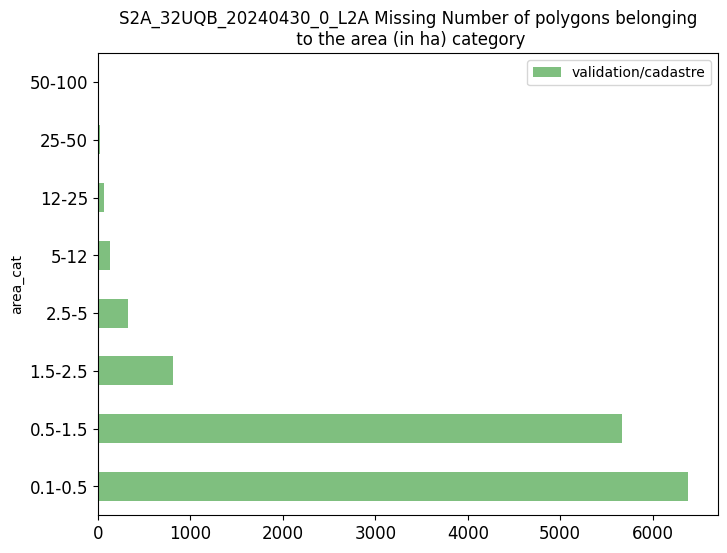

In [125]:
visualize_missing_stats(fields_val, fields_intersect_ids=fields_intersect["idx_fields_val"], 
                            title='validation/cadastre', 
                            tile_id=tile_id, list_areas=list_areas, areas_cat=areas_cat, plot_field=False)

C:\Users\alena.bakhoryna\AppData\Local\anaconda3\envs\nivaenv\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\alena.bakhoryna\AppData\Local\anaconda3\envs\nivaenv\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


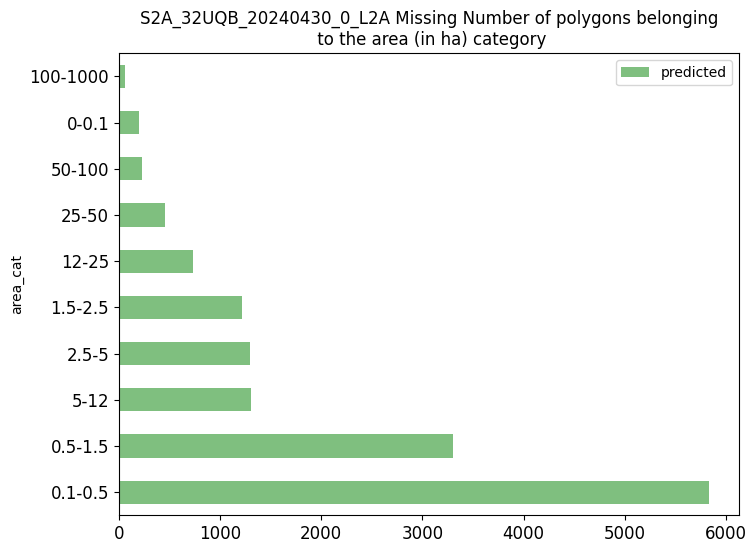

In [126]:
visualize_missing_stats(fields, fields_intersect_ids=fields_intersect["idx_fields"], 
                            title='predicted', 
                            tile_id=tile_id, list_areas=list_areas, areas_cat=areas_cat, plot_field=False)

In [17]:
max_val_fields_idx = fields_intersect.iloc[fields_intersect["fields_val_area"].argmax()].idx_fields_val
sub_fields_intersect = fields_intersect[fields_intersect.idx_fields_val == max_val_fields_idx]
sub_fields_intersect

,idx_fields_val,geom_fields_val,idx_fields,geom_fields,fields_val_area,fields_area
27178,22248,"POLYGON ((758076.628 5656191.281, 758076.984 5...",30299.0,"POLYGON ((758096.083 5653238.75, 758085.05 565...",5.595568e+06,1.281320e+03
27179,22248,"POLYGON ((758076.628 5656191.281, 758076.984 5...",29398.0,"POLYGON ((759005.917 5653911.25, 758956.25 565...",5.595568e+06,2.421965e+05
27180,22248,"POLYGON ((758076.628 5656191.281, 758076.984 5...",29409.0,"POLYGON ((759221.25 5654373.917, 759168.75 565...",5.595568e+06,1.826683e+04
27181,22248,"POLYGON ((758076.628 5656191.281, 758076.984 5...",27557.0,"POLYGON ((757668.5 5656158.75, 757706.25 56561...",5.595568e+06,1.002243e+04
27182,22248,"POLYGON ((758076.628 5656191.281, 758076.984 5...",30281.0,"POLYGON ((757021.25 5652608.219, 757001.583 56...",5.595568e+06,8.339172e+04
27183,22248,"POLYGON ((758076.628 5656191.281, 758076.984 5...",30280.0,"POLYGON ((757118.75 5652603.886, 757086.386 56...",5.595568e+06,1.739323e+05
27184,22248,"POLYGON ((758076.628 5656191.281, 758076.984 5...",30282.0,"POLYGON ((756936.25 5652612.135, 756801.25 565...",5.595568e+06,2.469547e+05
27185,22248,"POLYGON ((758076.628 5656191.281, 758076.984 5...",30284.0,"POLYGON ((757288.75 5652649.65, 757228.432 565...",5.595568e+06,3.643449e+05
27186,22248,"POLYGON ((758076.628 5656191.281, 758076.984 5...",30289.0,"POLYGON ((757608.75 5652789.058, 757589.795 56...",5.595568e+06,7.303982e+05
27187,22248,"POLYGON ((758076.628 5656191.281, 758076.984 5...",29396.0,"POLYGON ((757383.75 5654159.5, 757358.886 5654...",5.595568e+06,1.819096e+04


C:\Users\alena.bakhoryna\AppData\Local\anaconda3\envs\nivaenv\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


<AxesSubplot:>

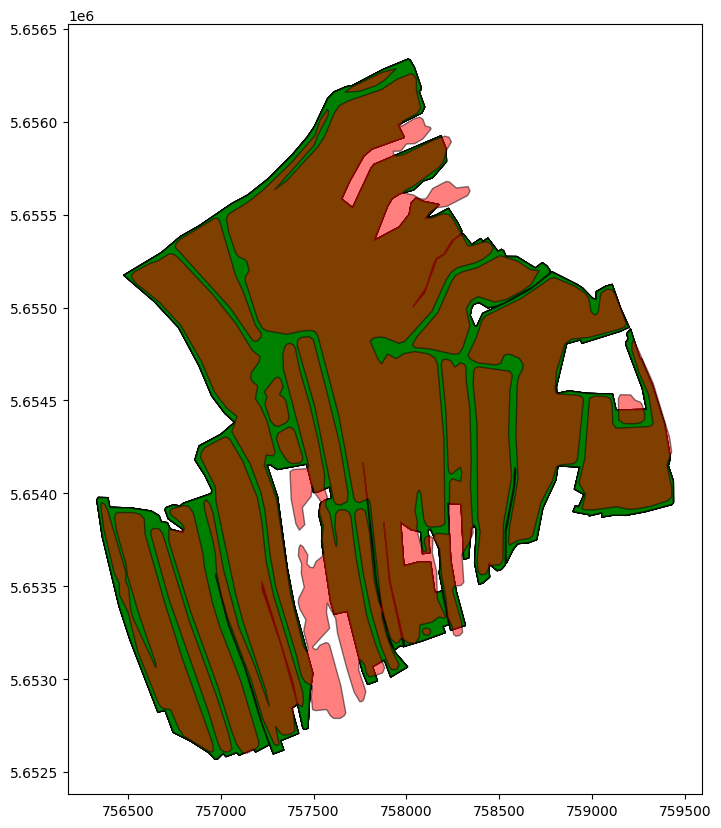

In [18]:
fig, axs = plt.subplots(figsize=(15, 10), ncols=1, sharey=True) # oversegmentation example
sub_fields_intersect.geom_fields_val.plot(ax=axs, color='green', alpha=0.5, edgecolor='k')
sub_fields_intersect.geom_fields.plot(ax=axs, color='red', alpha=0.5, edgecolor='k')

In [11]:
fields.crs == fields_val.crs, len(fields_val), len(fields), len(fields_intersect) 

(True, 59538, 63582, 70883)

In [121]:
fields_intersect, fields_intersect_m = metrics_computation(fields_intersect, col_max='ov_combined')

In [122]:
len(fields_intersect_m)

46134

In [24]:
fields_intersect.head(2)

,idx_fields_val,geom_fields_val,idx_fields,geom_fields,fields_val_area,fields_area,geom_fields_val_intersection,geom_fields_val_intersection_area,geom_fields_val_union,geom_fields_val_union_area
0,2,"POLYGON ((734747.474 5590218.075, 734726.794 5...",74363.0,"POLYGON ((734728.75 5590237.625, 734739.179 55...",5766.234414,3353.334557,"POLYGON ((734731.831 5590256.425, 734736.122 5...",3059.749966,"POLYGON ((734739.263 5590238.206, 734728.75 55...",6059.819005
1,5,"POLYGON ((734817.794 5590512.874, 734806.6 559...",74381.0,"POLYGON ((734831.25 5590527.205, 734807.875 55...",9768.373755,7520.789645,"POLYGON ((734844.541 5590566.316, 734907.783 5...",5702.437506,"POLYGON ((734806.6 5590521.971, 734818.687 559...",11586.725894


In [92]:
fields_intersect_hds = fields_intersect[fields_intersect['HDS-0004'] > 0.9] # crop yield forecast requirements Use Case
len(fields_intersect_hds), 100 * len(fields_intersect_hds) / fields_intersect['idx_fields_val'].nunique()

(132, 0.2861230329041488)

In [96]:
fields_intersect_hds.idx_fields_val.nunique()

132

In [95]:
fields_intersect_hds.fields_val_area.describe()

count    1.320000e+02
mean     6.299825e+05
std      3.266325e+05
min      1.510113e+05
25%      4.236427e+05
50%      5.499138e+05
75%      7.461788e+05
max      2.386542e+06
Name: fields_val_area, dtype: float64

<AxesSubplot:>

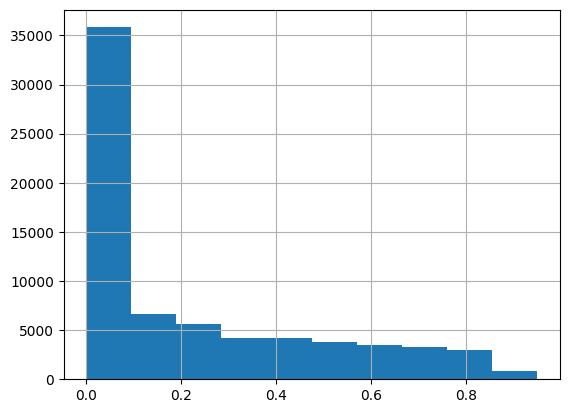

In [85]:
fields_intersect['HDS-0004'].hist(bins=10)

In [103]:
fields_intersect_m[['idx_fields_val', 'idx_fields', 'ov_val', 'ov_seg', 'ov_combined', 'ov_IoU', 'HDS-0004']].head(5)

,idx_fields_val,idx_fields,ov_val,ov_seg,ov_combined,ov_IoU,HDS-0004
0,2,74363.0,0.53,0.91,0.72,0.50,0.48
1,5,74381.0,0.58,0.76,0.67,0.49,0.40
2,6,74380.0,0.41,0.99,0.70,0.40,0.40
3,7,74420.0,0.13,0.01,0.07,0.01,0.00
4,8,74420.0,0.55,0.05,0.30,0.05,0.00


In [ ]:
fields_intersect_m[fields_intersect_m['ov_IoU'] == 0] # cause of rounding to 2 digits -> very small intersection area compared to hole area

In [37]:
len(fields_intersect_m), len(idx_max_overlap), len(fields_intersect)

(46134, 46134, 70883)

<AxesSubplot:>

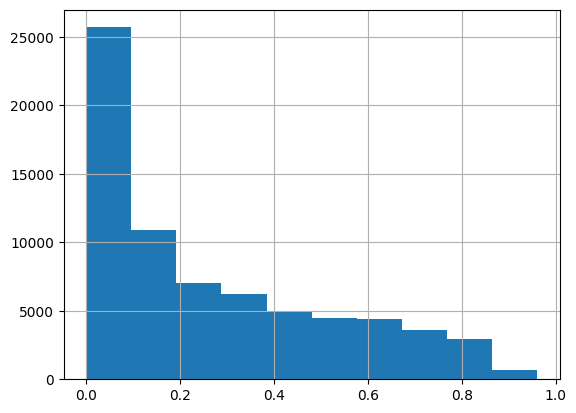

In [74]:
fields_intersect['ov_IoU'].hist(bins=10)

In [ ]:
# fields_intersect_hds

In [98]:
fields_intersect_hds = get_edge_metrics(fields_intersect_hds)

C:\Users\alena.bakhoryna\AppData\Local\anaconda3\envs\nivaenv\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\alena.bakhoryna\AppData\Local\anaconda3\envs\nivaenv\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\alena.bakhoryna\AppData\Local\anaconda3\envs\nivaenv\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarni

In [105]:
# summarise stats for all fields
print(f"areal stats")
print(fields_intersect_m[['ov_val', 'ov_seg', 'ov_combined', 'ov_IoU', 'HDS-0004']].mean(numeric_only=True).round(2))

print(f"\nedge-based stats")
print(fields_intersect_hds[["mae_val", "mae_seg", "mae_combined", "hausdorff_dist"]].mean(numeric_only=True).round(2))

areal stats
ov_val         0.52
ov_seg         0.68
ov_combined    0.60
ov_IoU         0.36
HDS-0004       0.30
dtype: float64

edge-based stats
mae_val           15.29
mae_seg           14.50
mae_combined      29.79
hausdorff_dist    61.48
dtype: float64


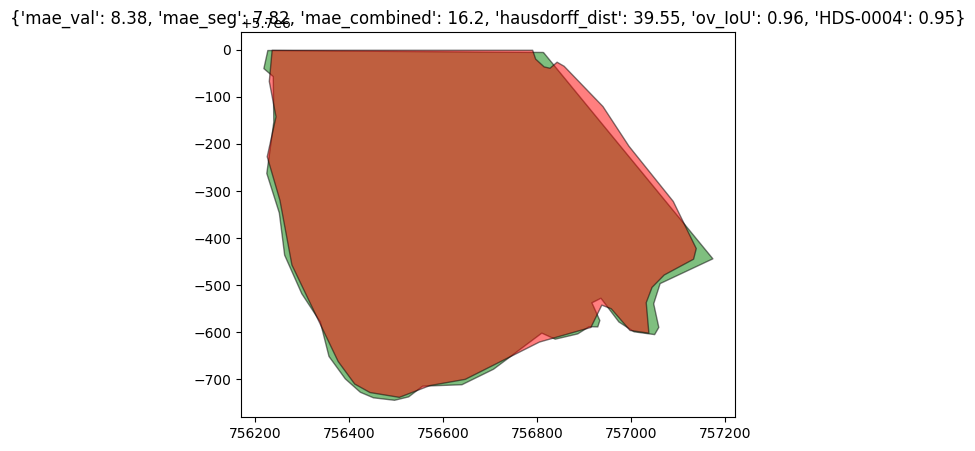

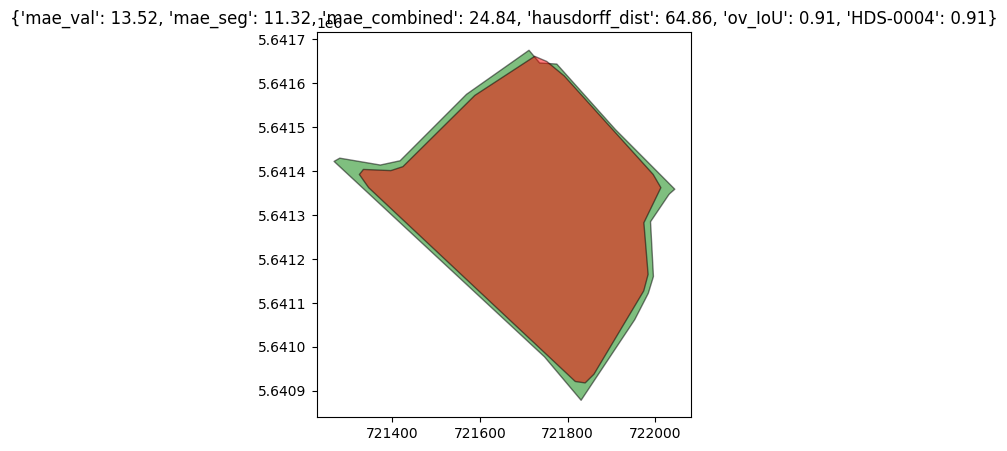

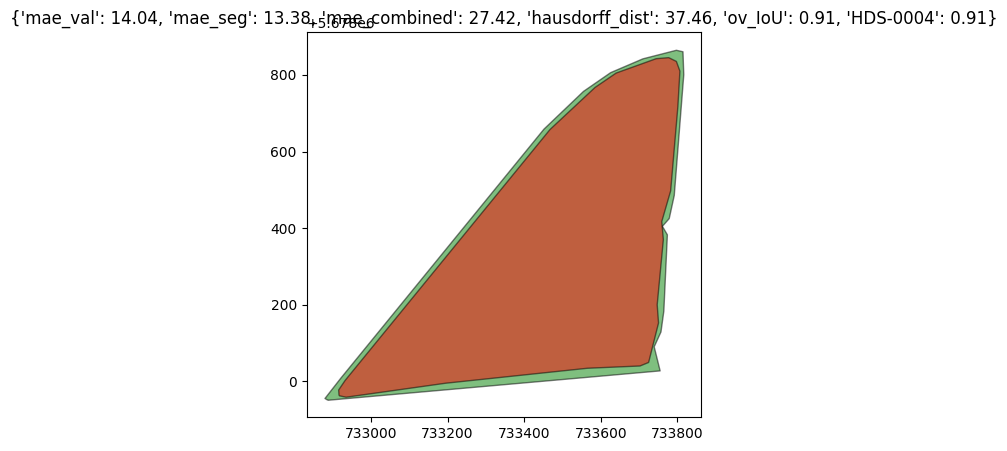

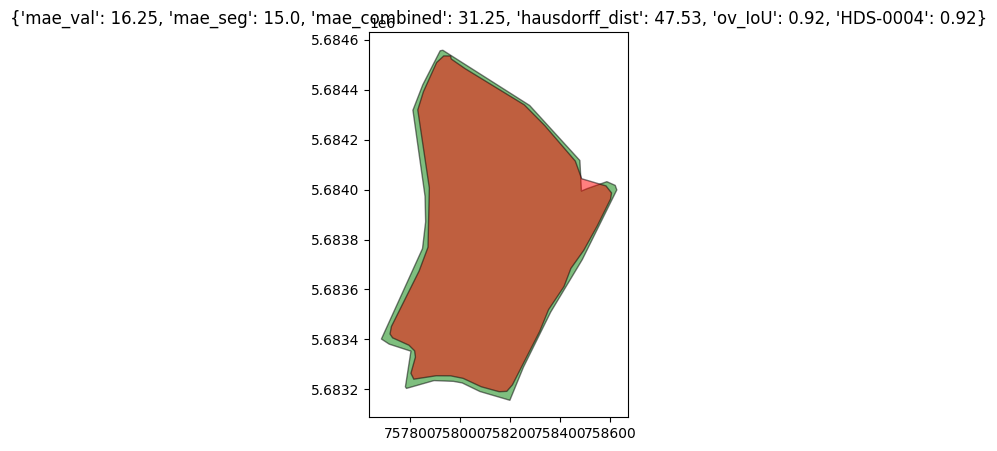

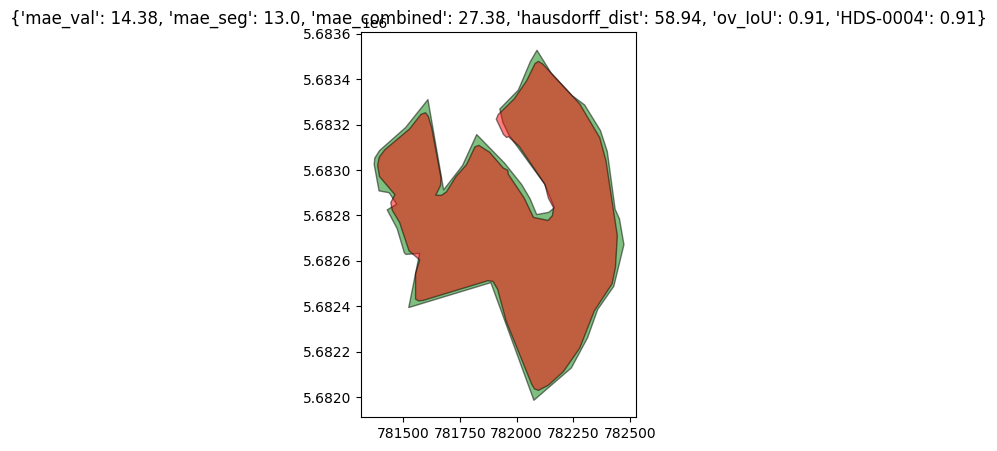

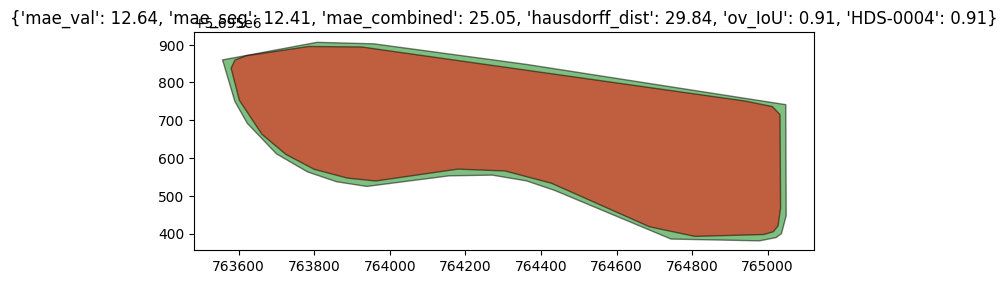

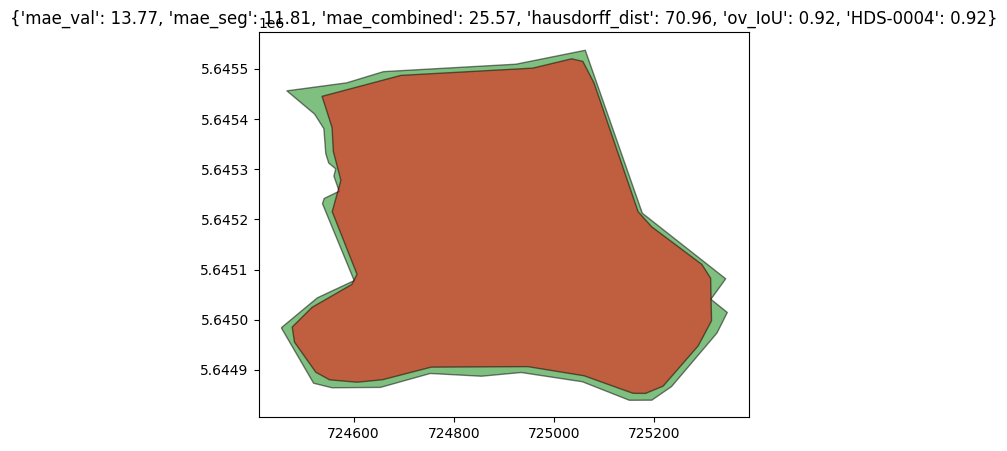

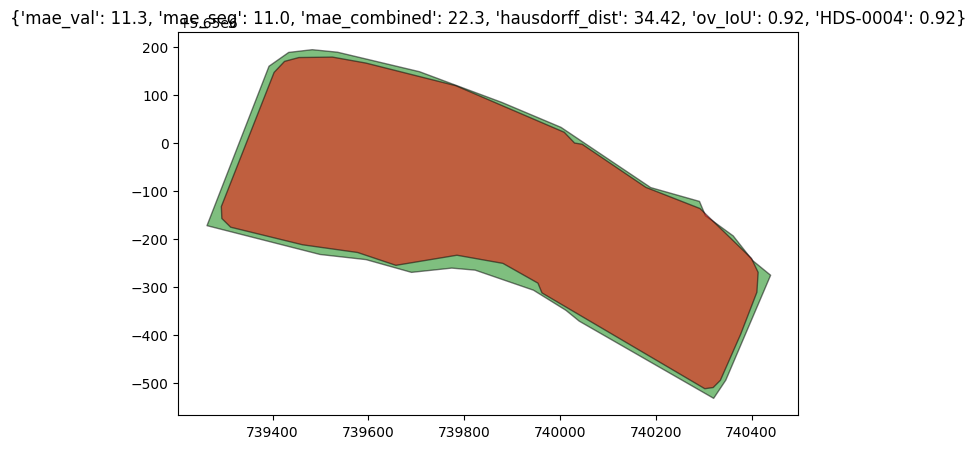

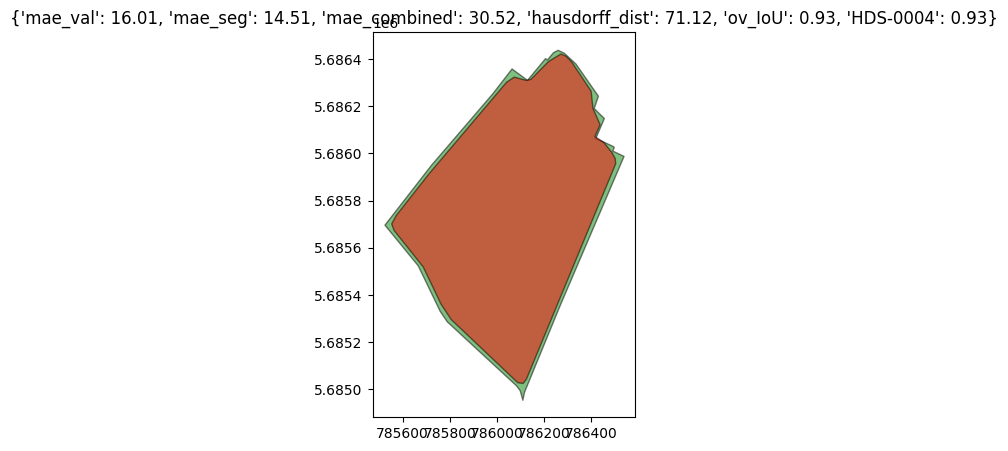

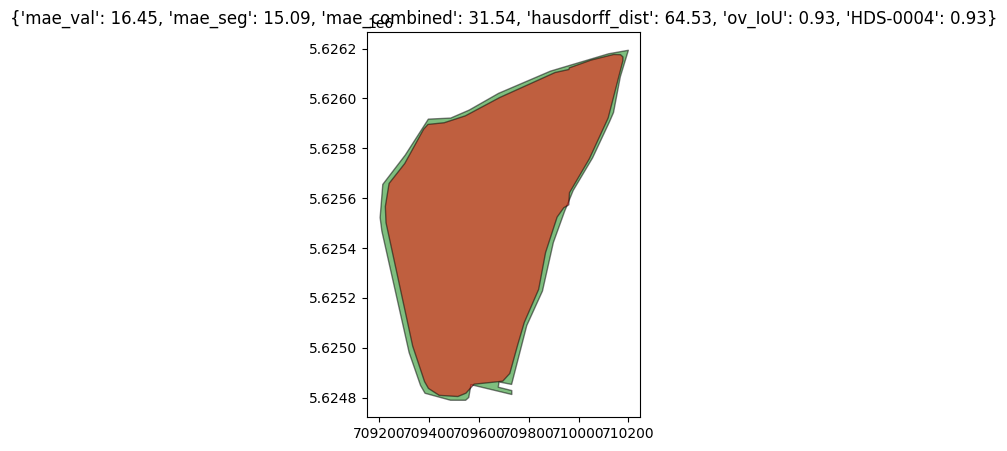

In [115]:
for idx in random.sample(range(0, len(fields_intersect_hds)), 10):
    df = fields_intersect_hds.iloc[idx:idx+1]
    fig, axs = plt.subplots(figsize=(8, 5), ncols=1, sharey=True) # 
    df.geom_fields_val.plot(ax=axs, color='green', alpha=0.5, edgecolor='k')
    df.geom_fields.plot(ax=axs, color='red', alpha=0.5, edgecolor='k') # plotly ???? interactive
    _ = axs.set_title(f'{df[["mae_val", "mae_seg", "mae_combined", "hausdorff_dist", "ov_IoU", "HDS-0004"]].round(2).iloc[0].to_dict()}')
    plt.show()